In [3]:
import torch
import torch.distributions as dist
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Transforming probability distributions
Normalizing flows uses transformation to obtain complex posteriors. 
This notebook explores transformations of distributions.

We start with a basis Gaussian $\mathcal{N}(\mu=1, \sigma=0.1)$. These parameters are chose so we can look at transformations in the positive domain and don't have trouble with square rooting negative numbers.

Below we plot the **pdf** and integrate to validate $\int P(x)dx=1$.

1.0

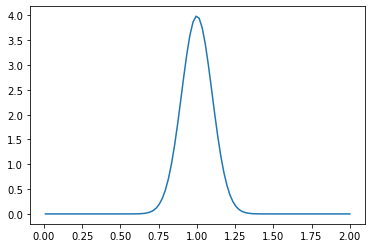

In [221]:
x = np.linspace(0.01, 2, num=100)

base = stats.norm(1, 0.1)

plt.plot(x, base.pdf(x))

np.trapz(base.pdf(x), x)

## Transformation

As we apply $f(x) = y = x^2$ we see that the result of the transformation doesn't suffice the requirements of a probability distribution, as $\int P(y)dy \neq 1$

5.641895835477563

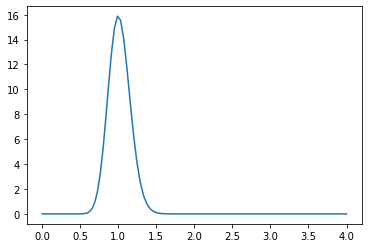

In [222]:
def f(x):
    return x**2

transformed = f(base.pdf(x))
plt.plot(f(x), transformed)

np.trapz(transformed, f(x))

# Change of variables

We want to transform $P(x)$ to $P(y)$ with $f: \mathbb{R}^n \mapsto \mathbb{R}^n $ and $f(x) = y$
The transformation blows up or shrinks the area/ volume (in N-D) of the distribution, so we need to determine a transformation so that:


$$ 
\begin{eqnarray}
\int P(x)dx &=&\int P(y)dy = 1 \\
P(x)dx &=&P(y)dy \\
P(y) &=&P(x)\frac{dx}{dy}
\end{eqnarray} $$

So to keep an integral of 1 for $P(y)$ (the definition of a probability distribution), we need to multiply $P(x)$ with its derivative w.r.t. $y$.
Therefore we need to express $x$ in $y$. This can be done if we only have invertible transformations.

$$\begin{eqnarray}
f(x) &=& y \\
f^{-1}(y) &=& x
\end{eqnarray} $$

$$\begin{eqnarray}
 P(y) &=& P(x)\frac{\text{d}f^{-1}(y)}{\text{d}y} \\
 &=& P(x)f'^{-1}(y) \\
 &=& P(f^{-1}(y))f'^{-1}(y)
\end{eqnarray} $$


0.9987379589284238

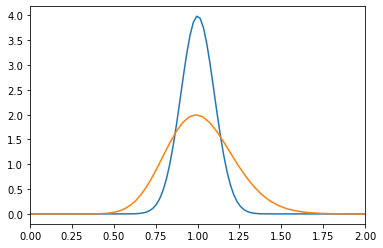

In [223]:
def f_i(y):
    return y**0.5

def f_i_prime(y):
    return 0.5*y**-0.5

assert np.allclose(f_i(f(x)),  x)

y = f(x)
px = base.pdf(x)

transformed = px * f_i_prime(f_i(y))

plt.plot(x, px)
plt.plot(y, transformed)
plt.xlim(0, 2)

np.trapz(transformed, y)

0.9987894616589735

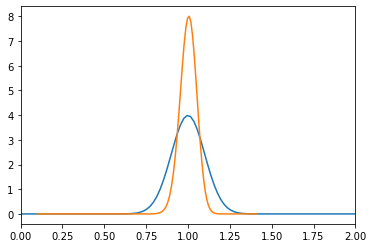

In [224]:
# Same principle, other transformation

def f(x):
    return x**0.5

def f_i(y):
    return y**2

def f_i_prime(y):
    return 2*x

assert np.allclose(f_i(f(x)),  x)

y = f(x)
px = base.pdf(x)

transformed = px * f_i_prime(f_i(y))

plt.plot(x, px)
plt.plot(y, transformed)
plt.xlim(0, 2)

np.trapz(transformed, y)

## Conditions
The transformations we've used were strictly increasing. 

In the example we've used above $\frac{dx}{dy}$ was positive, as the transformation was strictly increasing, in the strictly decreasing case, $\frac{dx}{dy}$ is negative and $P(y)=-P(x)\frac{dx}{dy}$. If we take the absolute value of the derivative we have one equation for both cases.

$$ 
\begin{eqnarray}
P(y)&=&P(x) \cdot \left| \frac{dx}{dy} \right| \\
 &=& P(f^{-1}(y)) \cdot \left| f'^{-1}(y)\right|
\end{eqnarray}
$$

The intuition of taking the modulus is that if the (local) rate of change of $x + dx = y + dy > 0$, than we can ensure ourselves that the rate of amount of probability is increasing, and the total amount of probability is preserved. This is ensured by conditioning $\frac{dx}{dy} \geq 0$.

![](img/absolute.png)

## Multiple dimensions
In N-D $\frac{dx}{dy}$ is expressed in the Jacobian matrix, i.e. the matrix with first order partial derivatives $\frac{\partial(x)}{\partial{y}}=\mathbf{J}$. This absolute value, is now a determinant, such that;

$$ 
\begin{eqnarray}
P(y)&=&P(f^{-1}(y)) \cdot \left| \det \frac{\partial{ f(y)^{-1} }}{\partial{y}} \right| \\
P(y)&=&P(f^{-1}(y)) \cdot \left| \det \mathbf{J}_{f^{-1}}(y) \right| \\
\end{eqnarray}
$$

The geometric meaning of the determinant is a scaling factor. $\det A$ tells us how much an n-dimensional volume is scaled by applying the transformation of $A$.

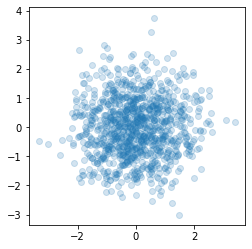

In [22]:
m = dist.Normal(torch.zeros(2), scale=torch.ones(2))
s = m.sample((1000,))

plt.scatter(s[:, 0], s[:, 1], alpha=0.2)
plt.axis('scaled');

In [23]:
def f(x):
    torch.exp(x) + 2
    
